In [1]:
'''This script demonstrates ICM on image data

 #Reference
 - Curiosity-driven Exploration by Self-supervised Prediction https://arxiv.org/abs/1705.05363
 - rubiks-dataset https://github.com/tik0/rubiks-dataset
'''

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras
import vae_tools.loader as loader

Configure and load the data

In [2]:
epochs = 100           # Training steps 
target_size = (30, 40) # Image size

# Load the data
action_train, v1_train, v2_train, _, _ = loader.rubiks(num_tuples = int(10000), target_size = (30, 40), working_dir = '/tmp')

Found 27 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 29 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 19 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Found 49 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


Configure and build the ICM

Model: "icm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feat_inp_s2 (InputLayer)        [(None, 3600)]       0                                            
__________________________________________________________________________________________________
feat_inp_s1 (InputLayer)        [(None, 3600)]       0                                            
__________________________________________________________________________________________________
feat_model_s2 (Model)           (None, 2)            115802      feat_inp_s2[0][0]                
                                                                 feat_inp_s2[0][0]                
__________________________________________________________________________________________________
a (InputLayer)                  [(None, 3)]          0                                    

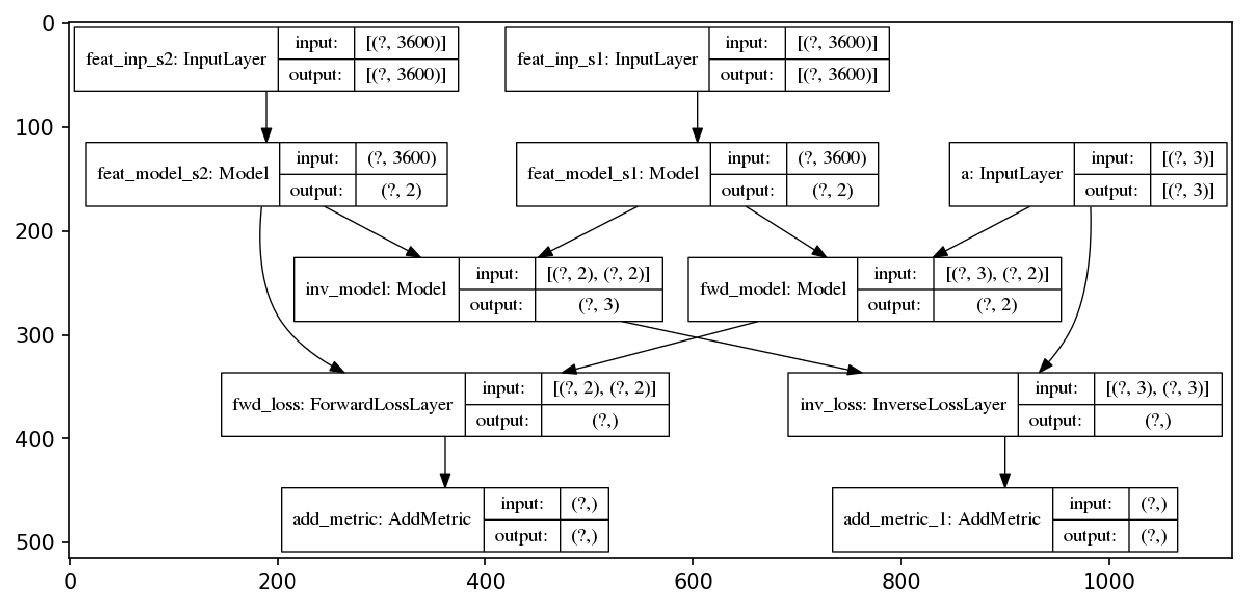

In [3]:
# Define the ICM

# input image dimensions and config
batch_size = 128
image_rows_cols_chns = (target_size[0], target_size[1], 3)
original_dim = np.prod(image_rows_cols_chns)
action_dim = 3
feat_dim = 2
intermediate_dim = 32
intermediate_dim_2 = int(intermediate_dim / 2.)
beta = 0.1 # in the paper beta := 0.2

# Feature extractor
feat_trainable = True
feat_inp_s1 = Input(shape=(original_dim,), name="feat_inp_s1")
feat_inp_s2 = Input(shape=(original_dim,), name="feat_inp_s2")
feat_h1  = Dense(intermediate_dim, activation='elu', name="feat_h1", trainable=feat_trainable)
feat_d1  = Dropout(rate=0.4, name="feat_d1")
feat_h2  = Dense(intermediate_dim_2, activation='elu', name="feat_h2", trainable=feat_trainable)
feat_d2  = Dropout(rate=0.4, name="feat_d2")
feat_out  = Dense(feat_dim, name="feat_out", trainable=feat_trainable)
feat_out_bn = keras.layers.BatchNormalization()

# w/o dropout
#feat_model_s1 = Model(feat_inp_s1, feat_out(feat_h2(feat_h1(feat_inp_s1))), name="feat_model_s1")
#feat_model_s2 = Model(feat_inp_s2, feat_out(feat_h2(feat_h1(feat_inp_s2))), name="feat_model_s2")
# w/ dropout
#feat_model_s1 = Model(feat_inp_s1, feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s1))))), name="feat_model_s1")
#feat_model_s2 = Model(feat_inp_s2, feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s2))))), name="feat_model_s2")
# w/ dropout and batchnorm
feat_model_s1 = Model(feat_inp_s1, feat_out_bn(feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s1)))))), name="feat_model_s1")
feat_model_s2 = Model(feat_inp_s2, feat_out_bn(feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s2)))))), name="feat_model_s2")

# Inverse model (action predictor)
fwd_feat_inp_s1 = Input(shape=(feat_dim,), name="fwd_feat_inp_s1")
fwd_feat_inp_s2 = Input(shape=(feat_dim,), name="fwd_feat_inp_s2")
inv_concat = keras.layers.Concatenate(axis=-1, name="inv_concat")
inv_h1  = Dense(intermediate_dim_2, activation='elu', name="inv_h1")
inv_d1  = Dropout(rate=0.4, name="inv_d1")
inv_h2  = Dense(intermediate_dim_2, activation='elu', name="inv_h2")
inv_d2  = Dropout(rate=0.4, name="inv_d2")
inv_out = Dense(action_dim, name="inv_out")

# w/o dropout
#inv_model = Model([fwd_feat_inp_s1, fwd_feat_inp_s2], inv_out(inv_h2(inv_h1(inv_concat([fwd_feat_inp_s1, fwd_feat_inp_s2])))), name="inv_model")
# w/ dropout
inv_model = Model([fwd_feat_inp_s1, fwd_feat_inp_s2],
                  inv_out(inv_d2(inv_h2(inv_d1(inv_h1(inv_concat([fwd_feat_inp_s1, fwd_feat_inp_s2])))))), name="inv_model")

# Forward model (feature predictor)
fwd_trainable = True
fwd_inp = Input(shape=(action_dim,), name="a")
fwd_concat = keras.layers.Concatenate(axis=-1, name="fwd_concat")
fwd_h1  = Dense(intermediate_dim_2, activation='elu', name="fwd_h1", trainable=fwd_trainable)
fwd_d1  = Dropout(rate=0.4, name="fwd_d1")
fwd_h2  = Dense(intermediate_dim_2, activation='elu', name="fwd_h2", trainable=fwd_trainable)
fwd_d2  = Dropout(rate=0.4, name="fwd_d2")
fwd_out = Dense(feat_dim, name="fwd_out", trainable=fwd_trainable)

# w/o dropout
fwd_model = Model([fwd_inp, fwd_feat_inp_s1], fwd_out(fwd_h2(fwd_h1(fwd_concat([fwd_inp, fwd_feat_inp_s1])))), name="fwd_model")
# w/ dropout
#fwd_model = Model([fwd_inp, fwd_feat_inp_s1], fwd_out(fwd_d2(fwd_h2(fwd_d1(fwd_h1(fwd_concat([fwd_inp, fwd_feat_inp_s1])))))), name="fwd_model")

# Define the losses

# loss layer
class InverseLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(InverseLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        fwd_inp = inputs[0]
        inv_out = inputs[1]
        batch = (1. - beta) * keras.losses.mse(fwd_inp, inv_out)
        loss = K.mean(batch)
        self.add_loss(loss, inputs=inputs)
        return batch
class ForwardLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(ForwardLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        feat_out_s2 = inputs[0]
        fwd_out = inputs[1]
        batch = beta * 0.5 * keras.losses.mse(feat_out_s2, fwd_out)
        loss = K.mean(batch)
        self.add_loss(loss, inputs=inputs)
        return batch

# Build the complete model
fwd_loss = ForwardLossLayer(name="fwd_loss")([feat_model_s2(feat_inp_s2), fwd_model([fwd_inp, feat_model_s1(feat_inp_s1)])])
inv_loss = InverseLossLayer(name="inv_loss")([fwd_inp, inv_model([feat_model_s1(feat_inp_s1), feat_model_s2(feat_inp_s2)])])
icm_model = Model([feat_inp_s1, feat_inp_s2, fwd_inp], [fwd_loss, inv_loss], name="icm_model")

# Add loss layer to the history
for output in icm_model.outputs:
    icm_model.add_metric(output, name=output.name.split(sep='/')[0], aggregation="mean")

# Compile and show it
icm_model.compile(keras.optimizers.Adam(lr=0.0001), loss=None)
icm_model.summary()
plot_model(icm_model, to_file='/tmp/ICM.png', show_shapes=True, show_layer_names=True)
f, ax = plt.subplots(1,1,figsize=(10, 10), dpi=150)
ax.imshow(mpimg.imread('/tmp/ICM.png'))
plt.show()

Train the ICM and show the results

In [4]:
# Train
X_train_s1 = v1_train
X_train_s2 = v2_train
X_train_actions = action_train
X_train_s1_flatten = X_train_s1.reshape((X_train_s1.shape[0], np.prod(X_train_s1.shape[1:])))
X_train_s2_flatten = X_train_s2.reshape((X_train_s2.shape[0], np.prod(X_train_s2.shape[1:])))
h = icm_model.fit([X_train_s1_flatten,
               X_train_s2_flatten,
               X_train_actions],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 0)

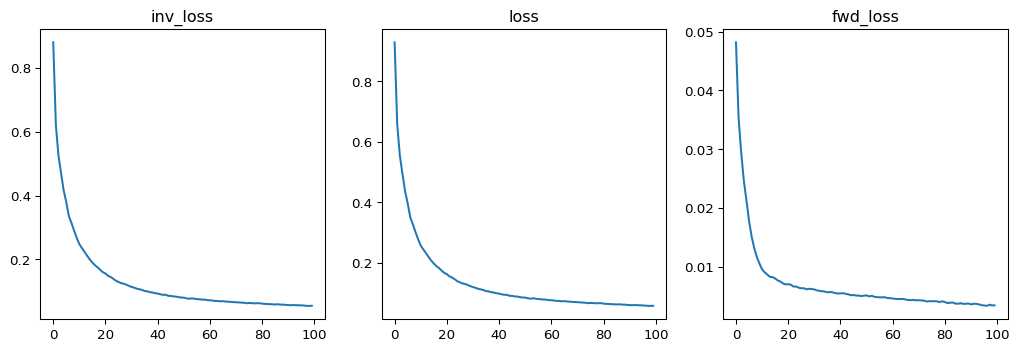

In [5]:
# Plot the losses

num_losses = len(h.history.keys())
f, ax = plt.subplots(1,num_losses, figsize=(13,4), dpi=96)
for k, idx in zip(h.history.keys(), range(num_losses)):
    ax[idx].plot(h.history[k])
    ax[idx].set_title(k)
plt.show()

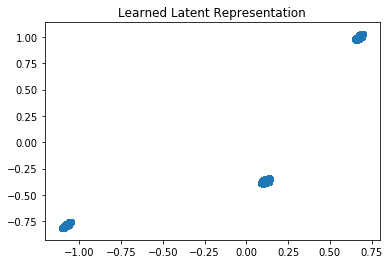

In [6]:
# Check the output distribution of the feature extractor
#X_train_flatten = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))
X_train_flatten = X_train_s1_flatten

X_train_feat = feat_model_s1.predict(X_train_flatten)
#c = np.concatenate(((pose_pitch_yaw - np.min(pose_pitch_yaw, axis=0)) / np.max(pose_pitch_yaw, axis=0), np.zeros((num_data,1))), axis=1)
#plt.scatter(X_train_feat[:,0], X_train_feat[:,1], c=c)
plt.scatter(X_train_feat[:,0], X_train_feat[:,1])
plt.title('Learned Latent Representation')
plt.show()

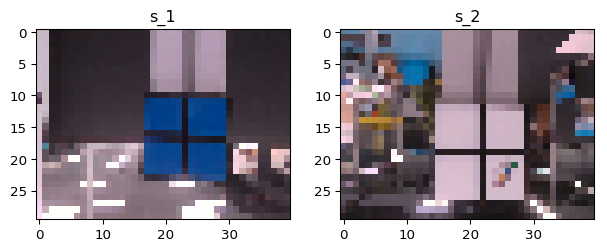

True: [1.  0.5 0. ]
 vs. 
Pred: [[0.92682314 0.40023175 0.13794348]]

Diff: 0.011445653197832565


In [7]:
# Check the inverse model (i.e. predicting the action from consecutive observations)
idx = 3
pred_action = inv_model.predict([feat_model_s1.predict(X_train_s1_flatten[[idx]]),
                                 feat_model_s1.predict(X_train_s2_flatten[[idx]])])
f, ax = plt.subplots(1,2,figsize=(7.5,7.5), dpi=96)
ax[0].imshow(X_train_s1[idx])
ax[1].imshow(X_train_s2[idx])
ax[0].set_title('s_1')
ax[1].set_title('s_2')
plt.show()
print("True: " + str(X_train_actions[idx]) + "\n vs. \nPred: " + str(pred_action))
print("\nDiff: " + str(np.mean((X_train_actions[idx] - pred_action)**2)))

In [8]:
# Check the forward model (i.e. predicting the next obs. from current action and obs.)
idx = 2
pred_obs = fwd_model.predict([X_train_actions[[idx]],
                              feat_model_s1.predict(X_train_s1_flatten[[idx]])])
pred_obs_gt = feat_model_s1.predict(X_train_s2_flatten[[idx]])
print("True: " + str(pred_obs_gt) + "\n vs. \nPred: " + str(pred_obs))
print("\nReward: " + str(np.mean((pred_obs_gt - pred_obs)**2)))


True: [[ 0.12507993 -0.34924787]]
 vs. 
Pred: [[ 0.1956431  -0.31011817]]

Reward: 0.0032551473


In [9]:
# store for visualization

import pickle
with open('icm.p', 'wb') as h:
    pickle.dump({'a': action_train, 'z': X_train_feat, 's': X_train_flatten},
                h,
                protocol=pickle.HIGHEST_PROTOCOL)